In [1]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from moviepy.editor import AudioFileClip, ImageClip
import IPython.display as ipd

from scipy.io import wavfile
from time import time

ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: N

# Audio Generation

In [2]:
freq_lim = (500, 2500)
sps = freq_lim[1]*2
power = 6
duration = 1
size = 2**power

In [3]:
sequence = ['A']
n = int(power)

for _ in range(n):
    new_sequence = []
    for item in sequence:
        if item=='A':
            new_sequence.extend(['+', 'B', 'F', '-', 'A', 'F', 'A', '-', 'F', 'B', '+'])
        elif item=='B':
            new_sequence.extend(['-', 'A', 'F', '+', 'B', 'F', 'B', '+', 'F', 'A', '-'])
        else:
            new_sequence.append(item)
    sequence = new_sequence
for i,item in enumerate(sequence):
    if item=='A' or item=='B':
        del sequence[i]
for i,item in enumerate(sequence):
    try:
        if item=='+' and sequence[i-1]=='-':
            del sequence[i]
            del sequence[i-1]
        elif item=='-' and sequence[i-1]=='+':
            del sequence[i]
            del sequence[i-1]
    except IndexError:
        continue
        
points = [(0,0)]
angle = 0
for item in sequence:
    if item=='F':
        new_point = (points[-1][0] + np.cos(angle), points[-1][1] + np.sin(angle))
        points.append(new_point)
    elif item=='+':
        angle+=np.pi/2
    elif item=='-':
        angle-=np.pi/2
points = np.round(np.array(points)).astype('int')

Total Time: 0.7781 seconds
Average Time: 0.0865 seconds


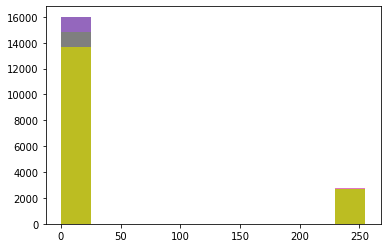

In [5]:
t0 = time()
image_list = glob.glob('images/*.png')
for image_file in image_list:
    
    #Get filename
    filename = image_file.split('/')[-1].split('.')[0]

    # Read image
    img = imread(image_file)
    plt.hist(img.flatten())
    img = resize(img, (size, size, 3))

    # Convert 2D image to 1D frequency
    amplitudes = np.array([rgb2gray(img[points[i,0], points[i,1]]) for i in range(len(points))], dtype='float32')
    frequencies = np.linspace(freq_lim[0], freq_lim[1], len(amplitudes), dtype='float32')
    
    # Convert 1D frequency to 1D time (adding sines)
    t = np.linspace(0,duration,sps, dtype='float32')
    total = np.zeros(sps, dtype='float32')
    for i,freq in enumerate(frequencies):
        total += amplitudes[i]*np.sin(2*np.pi*freq*(t-np.random.random()))
    total *= 100
    
    # Write .wav
    audio_file = os.path.join('audio', filename+'.wav')
    wavfile.write(audio_file, sps, total.astype(np.dtype('i2')))
    
#     # Write .mp4
#     img = (255*img).astype(np.uint8)
#     image_clip = ImageClip(img)
#     audio_clip = AudioFileClip(audio_file, fps=sps)
#     video_clip = image_clip.set_audio(audio_clip)
#     video_clip.duration = audio_clip.duration
#     video_clip.fps = 1
#     video_clip.write_videofile(os.path.join('video', filename+'.mp4'), verbose=False, logger=None)
    
print('Total Time: %0.4f seconds' % (time() - t0))
print('Average Time: %0.4f seconds' % ((time() - t0)/len(image_list)))

In [57]:
ipd.display(ipd.Audio('audio/dot0.wav', autoplay=True))

# Visualizing

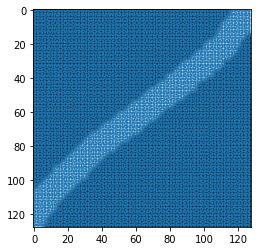

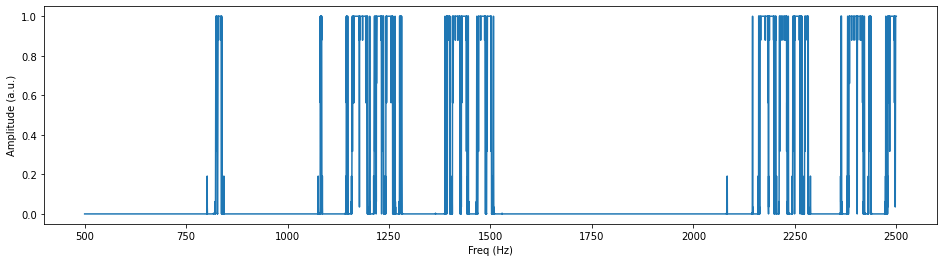

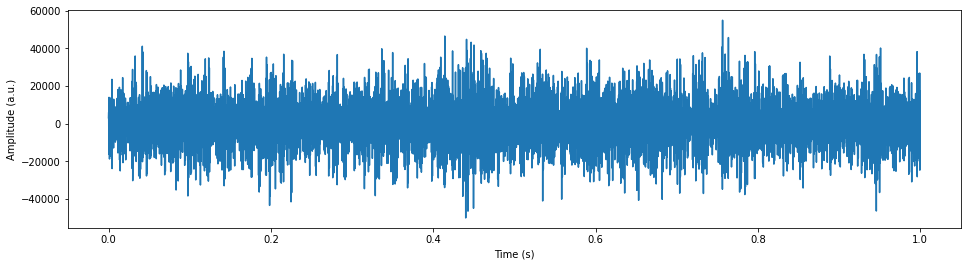

In [62]:
plt.imshow(img)
plt.plot(points[:,0], points[:,1])

plt.figure(figsize=(16,4))
plt.plot(frequencies, (np.abs(amplitudes)**2))
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude (a.u.)')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(t, total)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.show()